In [1]:
#ds imports
import pandas as pd
import numpy as np
import os
import wranglerer as wr
import modeling as md
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["font.size"] = 10
# splitting
from sklearn.model_selection import train_test_split
import scipy.stats as stats
# sklearn
import sklearn.preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
#CATboost imports
from catboost import CatBoostClassifier


## ACQUIRE

In [2]:
# read nba.csv and remove the Team Name Column.
df = wr.wrangle_nba()

In [3]:
df.head()

,fg_pct,opp_fg_pct,three_pt_pct,opp_three_pt_pct,ft_pct,rebounds,opp_rebounds,assists,steals,opp_steals,trnovrs_commited,pts,opp_pts,opp_fouls,prev_season,playoffs
0,0.464,0.458,0.173,0.251,0.771,46.3,44.2,23.5,9.6,8.4,18.3,105.2,102.3,26.6,1,1
1,0.490,0.470,0.384,0.286,0.779,43.3,40.7,25.9,9.5,8.1,18.1,109.4,101.9,24.2,0,1
2,0.484,0.496,0.255,0.271,0.779,42.4,41.5,25.5,8.3,10.0,19.9,104.3,107.0,26.1,0,0
3,0.474,0.501,0.193,0.291,0.772,42.0,44.1,24.0,8.7,8.1,15.6,106.7,106.4,23.2,0,0
4,0.463,0.492,0.325,0.327,0.737,44.7,44.1,24.2,8.7,9.5,17.9,103.4,107.6,23.7,1,0


## SUMMARY REPORT

In [4]:
# of Note, Zero Missingness!
wr.summarize(df)

SUMMARY REPORT


Dataframe head: 
   fg_pct  opp_fg_pct  three_pt_pct  opp_three_pt_pct  ft_pct  rebounds  \
0   0.464       0.458         0.173             0.251   0.771      46.3   
1   0.490       0.470         0.384             0.286   0.779      43.3   
2   0.484       0.496         0.255             0.271   0.779      42.4   
3   0.474       0.501         0.193             0.291   0.772      42.0   
4   0.463       0.492         0.325             0.327   0.737      44.7   

   opp_rebounds  assists  steals  opp_steals  trnovrs_commited    pts  \
0          44.2     23.5     9.6         8.4              18.3  105.2   
1          40.7     25.9     9.5         8.1              18.1  109.4   
2          41.5     25.5     8.3        10.0              19.9  104.3   
3          44.1     24.0     8.7         8.1              15.6  106.7   
4          44.1     24.2     8.7         9.5              17.9  103.4   

   opp_pts  opp_fouls  prev_season  playoffs  
0    102.3       26.6        

## UNIVARIATE HIST PLOTS

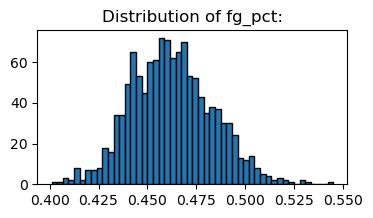

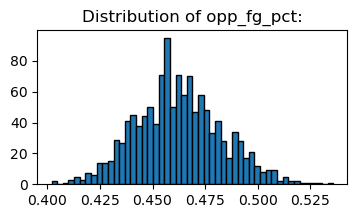

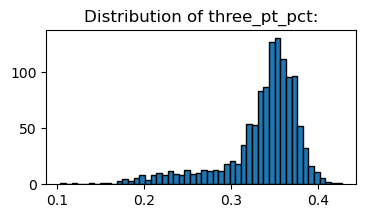

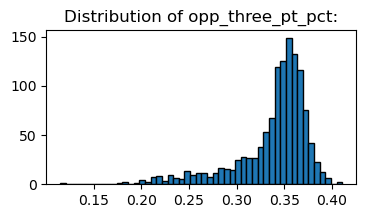

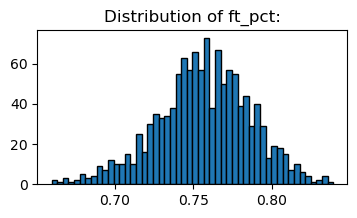

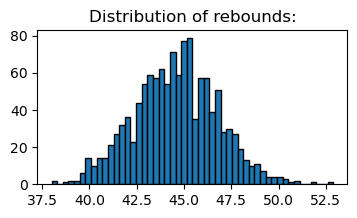

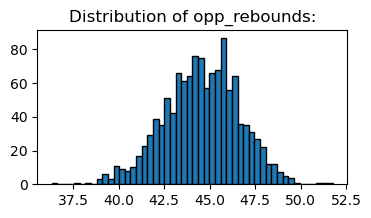

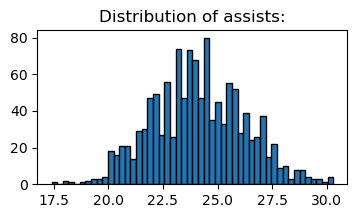

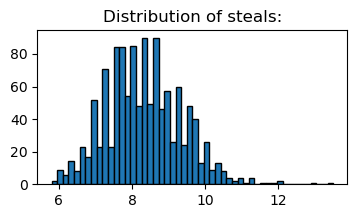

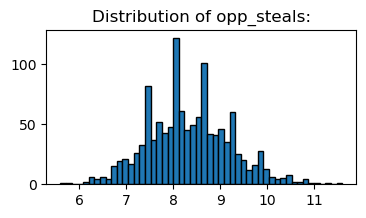

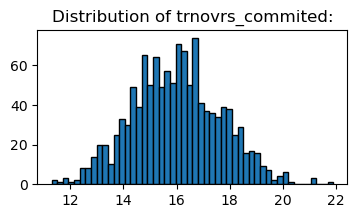

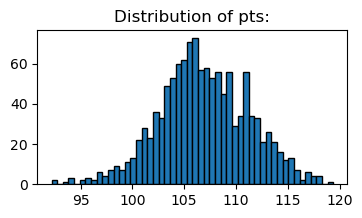

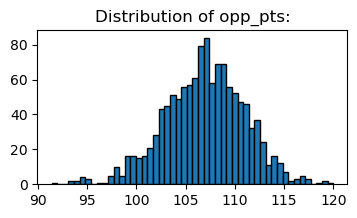

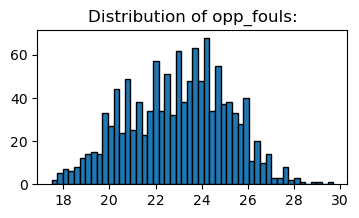

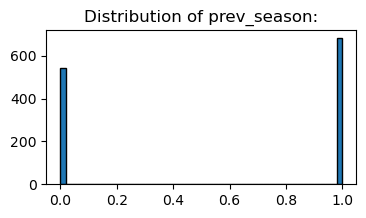

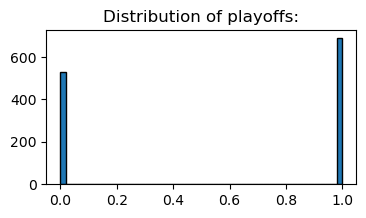

In [5]:
# Mostly Normal distributions!  3-Pt-Pct is left-skewed due to the learning curve required for teams to
# learn how to shoot 3-pointers effectively.
# Outliers exist, however they represent a small percentage of data points, for expediency, they will remain
# in the dataset.
wr.get_hist(df)

## SPLIT

In [6]:
train, validate, test = wr.split_data(df)
train.shape, validate.shape, test.shape

((732, 16), (271, 16), (221, 16))

## BI-VARIATE PLOTS Continuous vs Categorical

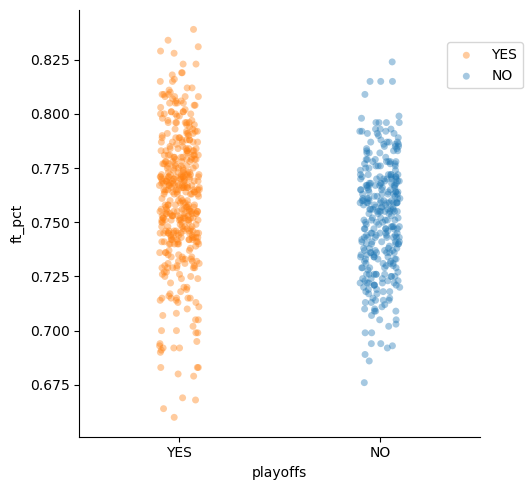

In [7]:
# DO Free Throws win games?
sns.catplot(data=train, x='playoffs', y='ft_pct',hue='playoffs',order=[1,0],alpha=0.4,ec='black')
plt.xticks(ticks=[0,1],labels=['YES','NO'])
plt.legend(labels=['YES','NO'],loc='lower left', bbox_to_anchor=(.9, .8))
plt.show()

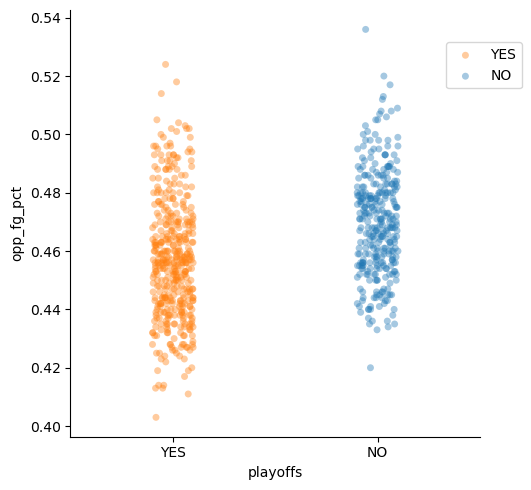

In [8]:
# How about solid, shutdown Defense?
sns.catplot(data=train, x='playoffs', y='opp_fg_pct',hue='playoffs',order=[1,0],alpha=0.4,ec='black')
plt.xticks(ticks=[0,1],labels=['YES','NO'])
plt.legend(labels=['YES','NO'],loc='lower left', bbox_to_anchor=(.9, .8))
plt.show()

# MEAN opp_points of Playoff teams vs MEAN opp_points of NON-Playoff teams
## Does a statistically significant difference exist between mean opp_points for playoff teams and that of 
## non-playoff teams?
### T-Test 2-sample, 2-tail

### Hypothesis

- ${H_0}$: No statistically significant difference exists between mean opp_points for playoff teams and that of non-playoff teams.
- ${H_a}$: A statistically significant difference exists between mean opp_points for playoff teams and that onon-playoff teams.

#### Two-tailed, Two-Sample T-Test ANY DIFF in mean between the two means

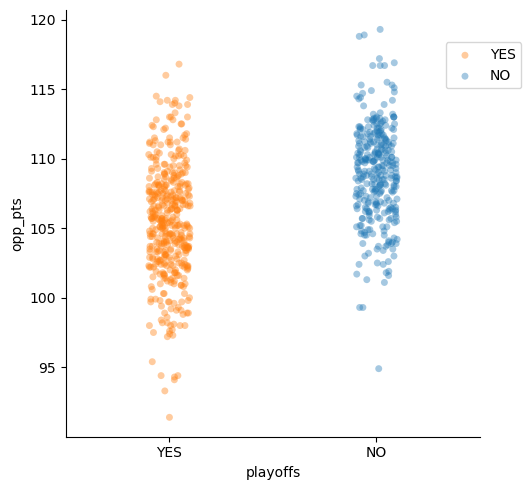

In [9]:
# Yes, defense does win games
sns.catplot(data=train, x='playoffs', y='opp_pts',hue='playoffs',order=[1,0],alpha=0.4,ec='black')
plt.xticks(ticks=[0,1],labels=['YES','NO'])
plt.legend(labels=['YES','NO'],loc='lower left', bbox_to_anchor=(.9, .8))
plt.show()

In [10]:
α = 0.05
opp_pts_playoff_values = train[train.playoffs == 1].opp_pts
opp_pts_nonplayoff_values = train[train.playoffs == 0].opp_pts
t, p = stats.ttest_ind(opp_pts_playoff_values,opp_pts_nonplayoff_values,equal_var=True)
print(t,p,α)
print(f'p = {p:e}')

-12.563677135487316 6.487650893466323e-33 0.05
p = 6.487651e-33


# with a p-value of close to Zero, Reject the NULL
### A statistically significant difference exists, there is evidence to suggest that the two samples were drawn from two independent underlying distributions.

## For those who like to look at numbers, look at all the differing means...

In [11]:
df_mean_by_playoffs = train.groupby(by='playoffs').mean()
df_mean_by_playoffs

,fg_pct,opp_fg_pct,three_pt_pct,opp_three_pt_pct,ft_pct,rebounds,opp_rebounds,assists,steals,opp_steals,trnovrs_commited,pts,opp_pts,opp_fouls,prev_season
playoffs,,,,,,,,,,,,,,,
0,0.452672,0.469608,0.334898,0.347860,0.751404,44.038854,45.357962,23.221975,8.104777,8.474204,16.217834,104.837261,108.976752,22.505732,0.305732
1,0.470160,0.456940,0.337084,0.332584,0.760400,44.830144,44.026077,24.810048,8.523684,8.174402,15.776316,108.600718,105.400239,23.288995,0.729665


## For those who like clusters...pts and opp_pts 
## Clustering looks very helpful, but for expediency, we will not dive into it during this sprint.

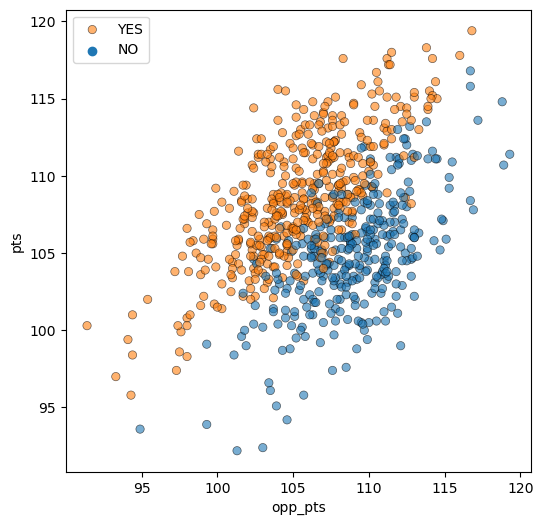

In [12]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=train.opp_pts, y=train.pts,hue=train.playoffs,ec='black',alpha=0.6)
plt.legend(labels=['YES','NO'],loc='upper left',)
plt.title('')
plt.show()

## Yes! A heatmap superimposed on a correlation matrix (everyone's fav)...

<AxesSubplot:>

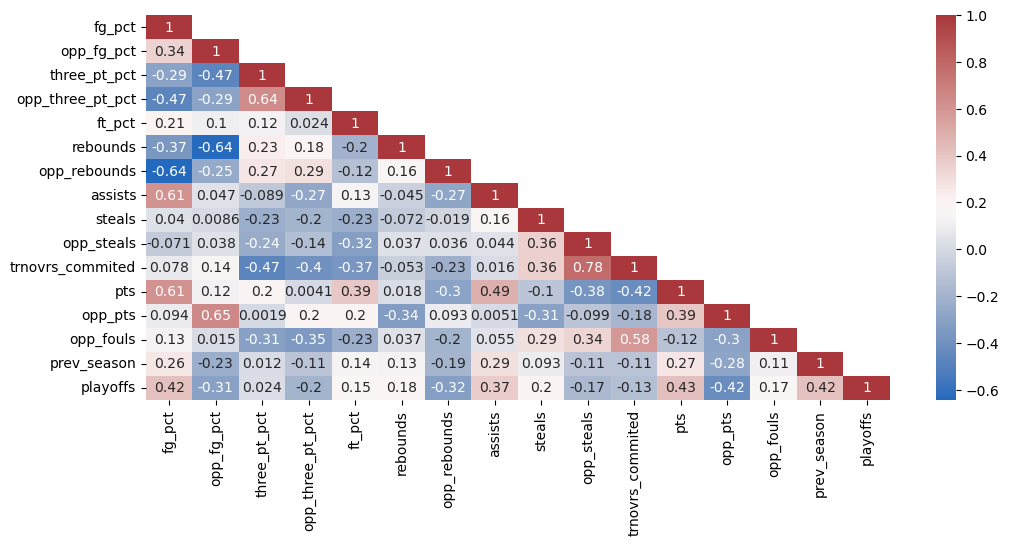

In [13]:
fig = plt.figure(figsize=(12,5))
sns.heatmap(train.corr(),
           cmap='vlag',
           annot=True,
           mask=np.triu(train.corr(),1))

## BI-VARIATE PLOTS Continuous vs Categorical

# opp_pts and opp_fg_pct correlation?
## Does a statistically significant correlation exist between mean rebounds and opp_fg_pct within the OVERALL sample?
### Pearson's R

### Hypothesis

- ${H_0}$: No statistically significant correlation exists between mean opp_pts and opp_fg_pct.
- ${H_a}$: A statistically significant correlation exists between mean opp_pts and opp_fg_pct
#### Pearson's R

In [14]:
α = 0.05

r, p = stats.pearsonr(train.opp_pts,train.opp_fg_pct)
print(r,p,α)
print(f'p = {p:e}')

0.6491284101821141 8.589460068737861e-89 0.05
p = 8.589460e-89


# with a p-value of close to Zero, Reject the NULL
### A statistically significant correlation exists, there is evidence to suggest that the two samples exhibit a linear relationship.

## MODELING

## Baseline

In [15]:
# When predicting "Playoffs" as a baseline for each team, recall is optimized at the expense of precision.
md.get_baseline(df)

baseline accuracy: 56.54%
baseline recall: 100.00%
baseline precision: 56.54%


####  As stated in the README, we shall optimize our models for Precision...the cost of a False Pos is greater than the cost of False Neg



## X_train, y_train, etc...

In [16]:
X_train, y_train, X_validate, y_validate, X_test, y_test = wr.train_validate_test(df,'playoffs')
X_train.shape, y_train.shape, X_validate.shape, y_validate.shape, X_test.shape, y_test.shape 

((732, 15), (732,), (271, 15), (271,), (221, 15), (221,))

## DTC maxDepth=4

In [17]:
# create the Decision Tree Classifier model 
dtc = DecisionTreeClassifier(max_depth=4)
# fit the model to the TRAIN dataset:
dtc.fit(X_train, y_train)
# use the model by calling for the predictions made via the TRAIN dataset
dtc_preds = dtc.predict(X_train)
pd.crosstab(dtc_preds,y_train) # a confusion matrix with ACTUALS as columns and PREDICTIONS as rows

playoffs,0,1
row_0,,
0,279,55
1,35,363


In [18]:
print(f'Accuracy-Train {round(dtc.score(X_train,y_train),4)}')
print(f'Accuracy-Validate {round(dtc.score(X_validate,y_validate),4)}')
print(classification_report(y_train,dtc_preds))
print(classification_report(y_validate,dtc.predict(X_validate)))

Accuracy-Train 0.877
Accuracy-Validate 0.8192
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       314
           1       0.91      0.87      0.89       418

    accuracy                           0.88       732
   macro avg       0.87      0.88      0.88       732
weighted avg       0.88      0.88      0.88       732

              precision    recall  f1-score   support

           0       0.77      0.81      0.79       114
           1       0.86      0.83      0.84       157

    accuracy                           0.82       271
   macro avg       0.81      0.82      0.82       271
weighted avg       0.82      0.82      0.82       271



## RFC maxDepth=6

In [19]:
# create the Random Forest model 
rf1 = RandomForestClassifier(n_estimators=201,max_depth=6,min_samples_leaf=1)
# fit the model to the TRAIN dataset1
rf1.fit(X_train, y_train)
# use the model by calling for the predictions made via the TRAIN dataset
rf1_preds = rf1.predict(X_train)
pd.crosstab(rf1_preds,y_train) # a confusion matrix with ACTUALS as columns and PREDICTIONS as rows

playoffs,0,1
row_0,,
0,304,8
1,10,410


In [20]:
print(f'Accuracy-Train {round(rf1.score(X_train,y_train),4)}')
print(f'Accuracy-Validate {round(rf1.score(X_validate,y_validate),4)}')
print(classification_report(y_train,rf1_preds))
print(classification_report(y_validate,rf1.predict(X_validate)))

Accuracy-Train 0.9754
Accuracy-Validate 0.8782
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       314
           1       0.98      0.98      0.98       418

    accuracy                           0.98       732
   macro avg       0.98      0.97      0.97       732
weighted avg       0.98      0.98      0.98       732

              precision    recall  f1-score   support

           0       0.89      0.81      0.85       114
           1       0.87      0.93      0.90       157

    accuracy                           0.88       271
   macro avg       0.88      0.87      0.87       271
weighted avg       0.88      0.88      0.88       271



## GradientBoostClassifier

In [21]:
# create the Random Forest model 
gbc = GradientBoostingClassifier()
# fit the model to the TRAIN dataset:
gbc.fit(X_train, y_train)
# use the model by calling for the predictions made via the TRAIN dataset
gbc_preds = gbc.predict(X_train)
pd.crosstab(gbc_preds,y_train) # a confusion matrix with ACTUALS as columns and PREDICTIONS as rows

playoffs,0,1
row_0,,
0,310,3
1,4,415


In [22]:
print(f'Accuracy-Train {round(gbc.score(X_train,y_train),4)}')
print(f'Accuracy-Validate {round(gbc.score(X_validate,y_validate),4)}')
print(classification_report(y_train,gbc_preds))
print(classification_report(y_validate,gbc.predict(X_validate)))

Accuracy-Train 0.9904
Accuracy-Validate 0.8819
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       314
           1       0.99      0.99      0.99       418

    accuracy                           0.99       732
   macro avg       0.99      0.99      0.99       732
weighted avg       0.99      0.99      0.99       732

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       114
           1       0.89      0.90      0.90       157

    accuracy                           0.88       271
   macro avg       0.88      0.88      0.88       271
weighted avg       0.88      0.88      0.88       271



## CATboost

In [23]:
# Create and fit the thing
CATb = CatBoostClassifier(verbose=False,depth=5)
CATb.fit(X_train,y_train)
CATb_preds = CATb.predict(X_train)
pd.crosstab(CATb_preds,y_train) # a confusion matrix with ACTUALS as columns and PREDICTIONS as rows

playoffs,0,1
row_0,,
0,309,6
1,5,412


In [24]:
print(f'Accuracy-Train {round(CATb.score(X_train,y_train),4)}')
print(f'Accuracy-Validate {round(CATb.score(X_validate,y_validate),4)}')
print(classification_report(y_train,CATb_preds))
print(classification_report(y_validate,CATb.predict(X_validate)))

Accuracy-Train 0.985
Accuracy-Validate 0.8745
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       314
           1       0.99      0.99      0.99       418

    accuracy                           0.98       732
   macro avg       0.98      0.98      0.98       732
weighted avg       0.98      0.98      0.98       732

              precision    recall  f1-score   support

           0       0.88      0.81      0.84       114
           1       0.87      0.92      0.90       157

    accuracy                           0.87       271
   macro avg       0.88      0.87      0.87       271
weighted avg       0.88      0.87      0.87       271



## Now We SCALE and run Models based on Scaled Values

In [25]:
sc_X = StandardScaler()
X_train_scaled = sc_X.fit_transform(X_train)
X_validate_scaled = sc_X.transform(X_validate)
X_test_scaled = sc_X.transform(X_test)

## MULTI-LAYER PERCEPTRON-set Hyperparameters to prevent full convergence on local minimum...induce some bias and increase generalizability of model.

In [26]:
mlp = MLPClassifier(hidden_layer_sizes=(256,128,64),activation="relu",random_state=2013,
                    batch_size=100,solver='sgd')
mlp.fit(X_train_scaled, y_train)
mlp_preds = mlp.predict(X_train_scaled)
print(mlp.score(X_train_scaled, y_train))
pd.crosstab(mlp_preds,y_train) # a confusion matrix with ACTUALS as columns and PREDICTIONS as rows

0.9344262295081968


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


playoffs,0,1
row_0,,
0,287,21
1,27,397


In [27]:
print(f'Accuracy-Train {round(mlp.score(X_train_scaled,y_train),4)}')
print(f'Accuracy-Validate {round(mlp.score(X_validate_scaled,y_validate),4)}')
print(classification_report(y_train,mlp_preds))
print(classification_report(y_validate,mlp.predict(X_validate_scaled)))

Accuracy-Train 0.9344
Accuracy-Validate 0.8856
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       314
           1       0.94      0.95      0.94       418

    accuracy                           0.93       732
   macro avg       0.93      0.93      0.93       732
weighted avg       0.93      0.93      0.93       732

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       114
           1       0.90      0.90      0.90       157

    accuracy                           0.89       271
   macro avg       0.88      0.88      0.88       271
weighted avg       0.89      0.89      0.89       271



## Logictic Regression

In [28]:
#C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs'
log = LogisticRegression()
log.fit(X_train_scaled, y_train)
log_preds = log.predict(X_train_scaled)
print(log.score(X_train_scaled, y_train))
pd.crosstab(log_preds,y_train) # a confusion matrix with ACTUALS as columns and PREDICTIONS as rows

0.9057377049180327


playoffs,0,1
row_0,,
0,275,30
1,39,388


In [29]:
print(f'Accuracy-Train {round(log.score(X_train_scaled,y_train),4)}')
print(f'Accuracy-Validate {round(log.score(X_validate_scaled,y_validate),4)}')
print(classification_report(y_train,log_preds))
print(classification_report(y_validate,log.predict(X_validate_scaled)))

Accuracy-Train 0.9057
Accuracy-Validate 0.8819
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       314
           1       0.91      0.93      0.92       418

    accuracy                           0.91       732
   macro avg       0.91      0.90      0.90       732
weighted avg       0.91      0.91      0.91       732

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       114
           1       0.89      0.90      0.90       157

    accuracy                           0.88       271
   macro avg       0.88      0.88      0.88       271
weighted avg       0.88      0.88      0.88       271



# FINAL TEST MODEL = Multi-Layer Perceptron
## 90% PRECISION for POS CLASS

In [31]:
print(f'Accuracy-Test {round(mlp.score(X_test_scaled,y_test),4)}')
print(classification_report(y_test,mlp.predict(X_test_scaled)))

Accuracy-Test 0.8778
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       104
           1       0.90      0.86      0.88       117

    accuracy                           0.88       221
   macro avg       0.88      0.88      0.88       221
weighted avg       0.88      0.88      0.88       221



## FEATURE IMPORTANCE

In [32]:
# According to DecisionTree
dtc_feat_df = pd.DataFrame(
    {'feat': X_train.columns.to_list(),
     'coef': dtc.feature_importances_
    }
)
dtc_feat_df.sort_values('coef',ascending=False).head()

,feat,coef
11,pts,0.356871
12,opp_pts,0.303726
14,prev_season,0.290094
2,three_pt_pct,0.023362
6,opp_rebounds,0.013489


In [33]:
# According to RandomForest
feat_df = pd.DataFrame(
    {'feat': X_train.columns.to_list(),
     'coef': rf1.feature_importances_
    }
)
feat_df.sort_values('coef',ascending=False).head()

,feat,coef
12,opp_pts,0.182012
11,pts,0.169667
0,fg_pct,0.102113
1,opp_fg_pct,0.086329
14,prev_season,0.072016


In [34]:
# According to LogRegressor
feat_df = pd.DataFrame(
    {'feat': X_train.columns.to_list(),
     'coef': log.coef_[0]
    }
)
feat_df['abs_val'] = abs(feat_df.coef)
feat_df.sort_values('abs_val',ascending=False).head()

,feat,coef,abs_val
12,opp_pts,-2.902446,2.902446
11,pts,2.774070,2.774070
10,trnovrs_commited,-0.708916,0.708916
0,fg_pct,0.635437,0.635437
1,opp_fg_pct,-0.512798,0.512798


## In Summary..."pts" and "opp_pts" were top 2 for all models